In [1]:
from pathlib import Path

import kornia.augmentation as K
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv

from estuary.model.config import EstuaryConfig
from estuary.model.data import EstuaryDataset, create_splits
from estuary.util.img import contrast_stretch, masked_contrast_stretch
from estuary.util.transforms import *

# Load environment variables from .env file
load_dotenv("../.env")

True

In [2]:
# idxes = np.random.randint(0, len(ds), 8)

In [3]:
conf = EstuaryConfig(
    data=Path("/Users/kyledorman/data/estuary/dataset/train_dataset.csv"),
    split_method="yearly",
    val_year=2023,
    test_year=2024,
    normalization_path=Path("/Users/kyledorman/data/estuary/dataset/normalization/stats.json"),
    batch_size=1,
)

df_train, df_val, df_test = create_splits(conf)

ds = EstuaryDataset(df_train, conf, train=True)

Some label classes will be ignored {'unsure'}


In [4]:
augs = []
if ds.norm_stats.power_scale:
    augs.append(PowerTransformTorch(ds.norm_stats.lambdas.tolist(), ds.norm_stats.max_pixel_value))
else:
    augs.append(ScaleNormalization(ds.norm_stats.max_pixel_value))


from estuary.util.transforms import RandomPlasmaFog

augs.append(
    RandomPlasmaFog(
        p=1.0,
        roughness=(0.4, 0.6),
        fog_intensity=(1.0, 1.0),
    )
)

augs += [
    K.Resize(size=(conf.val_size, conf.val_size)),
    K.Normalize(mean=ds.norm_stats.mean.tolist(), std=ds.norm_stats.std.tolist()),
]
transforms = K.AugmentationSequential(*augs, data_keys=None)

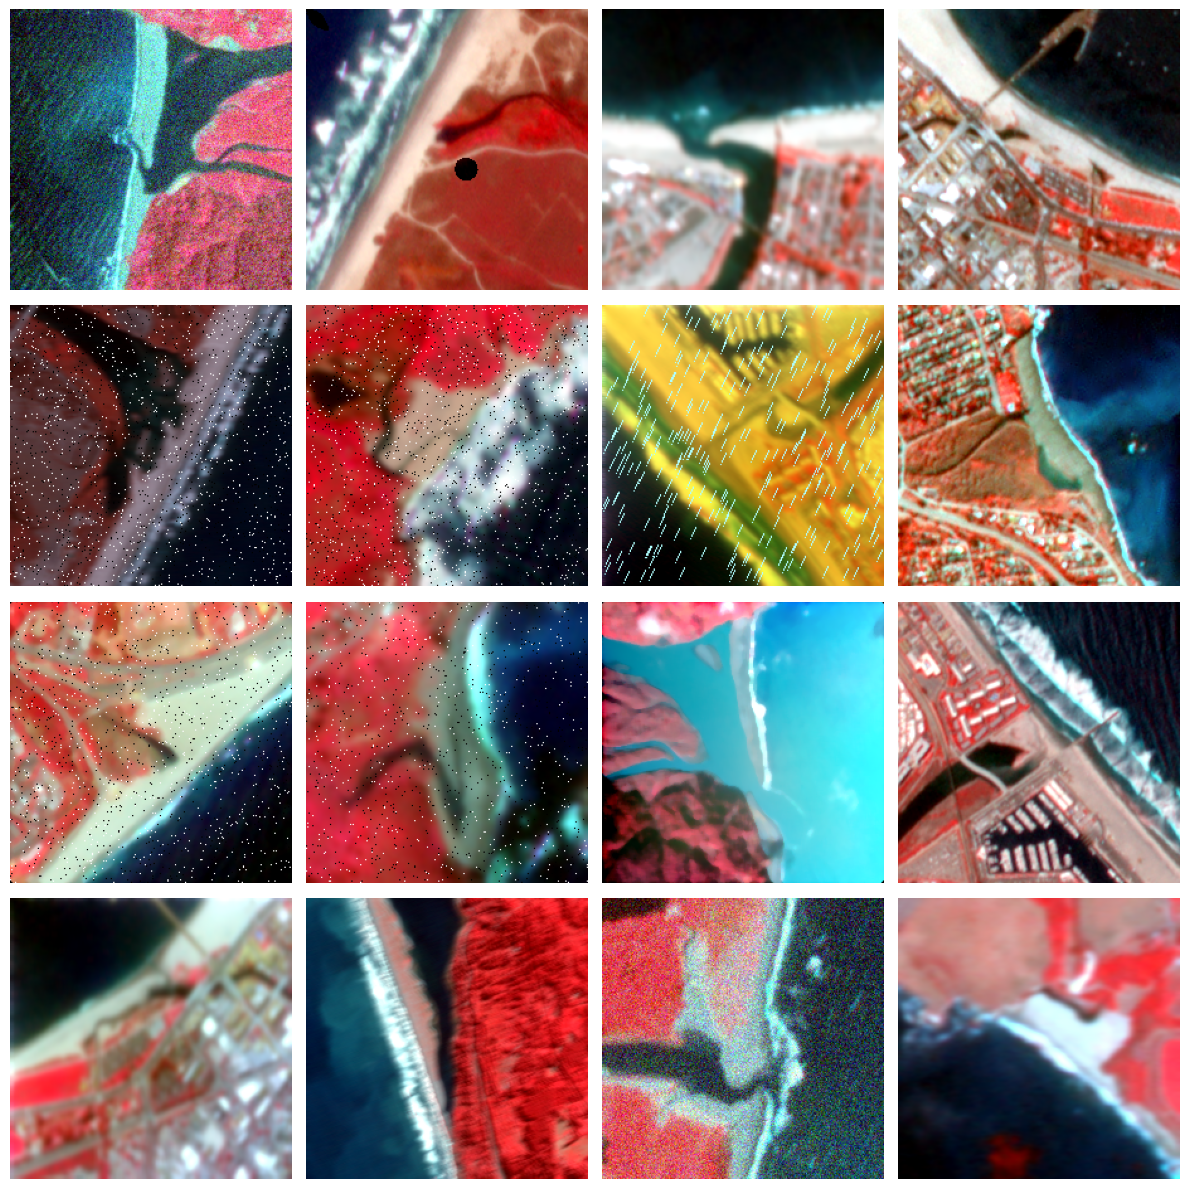

In [10]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(3 * 4, 3 * 4))
idxes = np.random.randint(0, len(ds), 16)
for ax, i in zip(axes.flatten(), idxes, strict=False):
    ax.axis("off")
    data = ds[i]
    data = ds.transforms(data)
    img = ds.denormalize(data["image"])[0].detach().cpu().numpy()
    nodata = (img == 0).all(axis=0)
    if not nodata.any():
        img = contrast_stretch(img)
    else:
        img = masked_contrast_stretch(img, ~nodata)
    ax.imshow(img.transpose((1, 2, 0)))

fig.tight_layout()
plt.show()